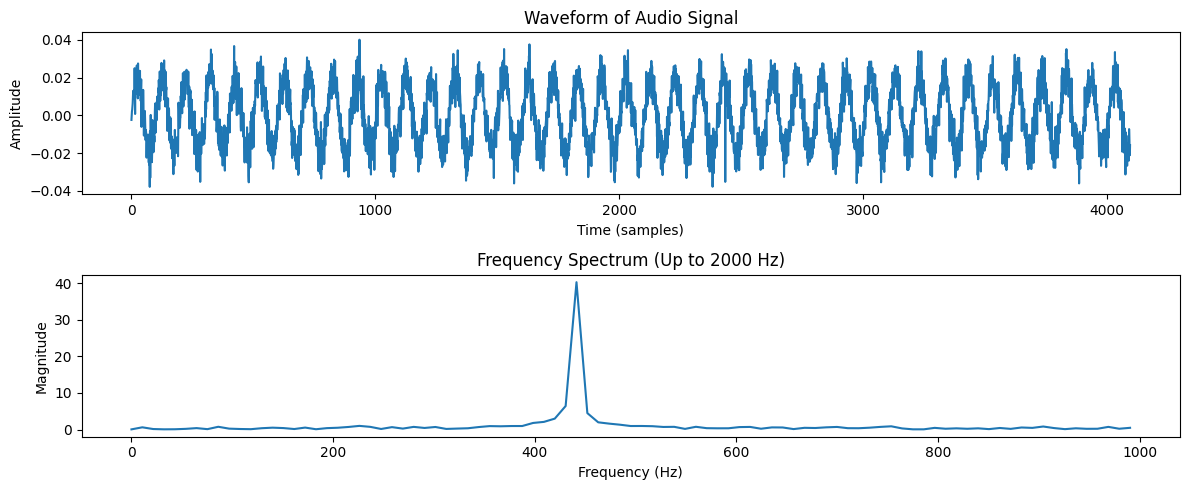

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from qiskit.primitives import Sampler, Estimator

sample_rate, audio = read("noisy_audio.wav")

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = audio[:, 0]


#manually add noise

# noise_intensity = 5000  
# noise = np.random.normal(0, noise_intensity, audio.shape)

# noisy_audio = np.int16(audio + noise)

# write("noisy_audio.wav", sample_rate, noisy_audio)


N = len(audio)
target_samples = 2**12
audio = audio[:target_samples]  # Truncate without padding
audio_segment = audio[:target_samples]

audio_segment = audio_segment/np.linalg.norm(audio_segment)
fft_result = fft(audio_segment)
frequencies = np.fft.fftfreq(target_samples, d=1/sample_rate)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 1000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()


441.4306640625
-441.4306640625


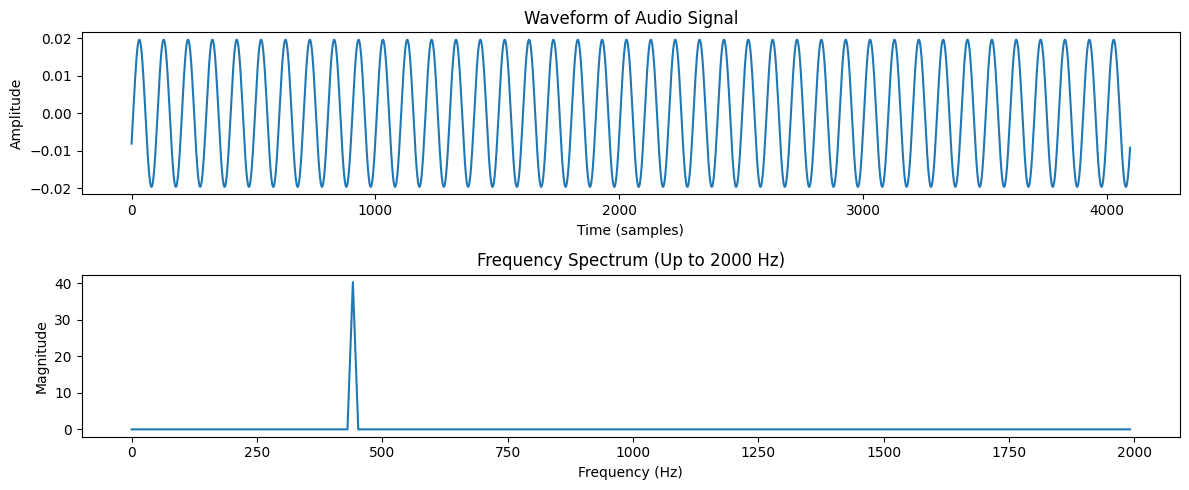

In [53]:
for i in range (0,target_samples):
    if np.abs(fft_result[i]) < 15:
        fft_result[i] = 0
    else:
        print(frequencies[i])


new_res = ifft(fft_result).real


plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(new_res)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()



In [52]:
filtered_audio = np.int16(ifft(fft_result).real) 

output_filename = "filtered_audio.wav"
write(output_filename, sample_rate, filtered_audio)

In [43]:
fft_result = fft(filtered_audio)
frequencies = np.fft.fftfreq(target_samples, d=1/sample_rate)

# Retune ratio (A440 to A415)
retune_ratio = 1/2 #double the frequencies

# New frequency bins after shifting
shifted_frequencies = frequencies * retune_ratio

# Interpolate FFT result to match new frequency bins
interp_func = interp1d(frequencies, fft_result, kind='linear', fill_value=0, bounds_error=False)
shifted_fft_result = interp_func(shifted_frequencies)


for i in range (0,target_samples):
    if np.abs(shifted_fft_result[i]) < 1000:
        shifted_fft_result[i] = 0


retuned_audio = np.int16(ifft(shifted_fft_result).real)


output_filename = "retuned_audio.wav"
write(output_filename, sample_rate, retuned_audio)

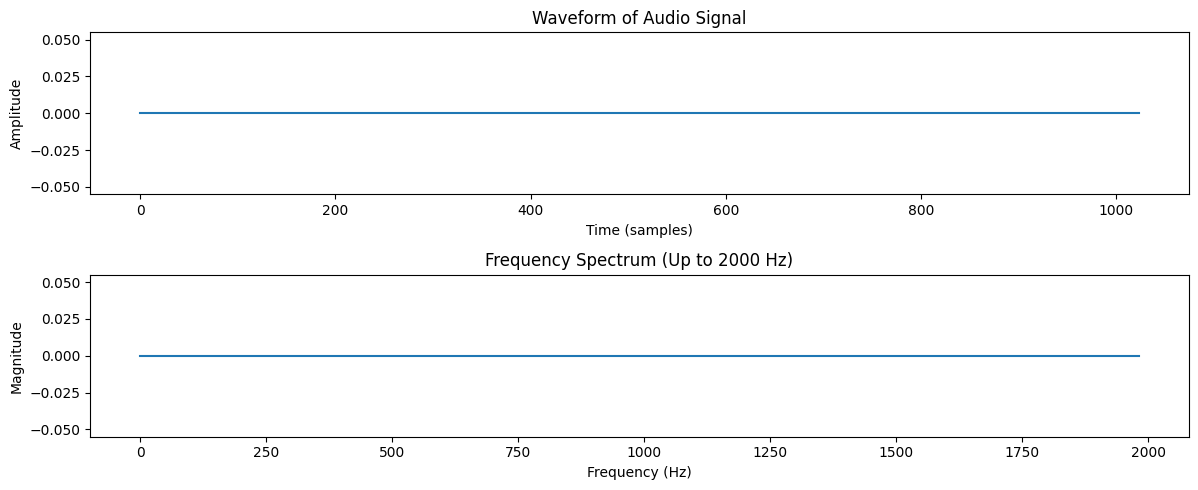

In [44]:
max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(retuned_audio)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(shifted_fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()


In [66]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator

def load_and_normalize_audio(filename):
    """Load an audio file and keep only the first 1024 samples (2^10)."""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    # Keep only the first 1024 samples
    target_samples = 2**13
    audio = audio[:target_samples]  # Truncate without padding

    print(f"Audio truncated to {target_samples} samples for 10 qubits.")

    # Normalize the audio for quantum state preparation
    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, 13

def prepare_quantum_state(normalized_audio, n_qubits):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)

    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))
    n_samples = len(normalized_audio)
    print(n_samples)
    return qc

In [ ]:


def denoise_oracle(statevector, threshold=0.05):

    probabilities = np.abs(statevector.data) ** 2

    for i in range (0,2**n_qubits):
        if probabilities[i] < threshold:
            statevector.data[i] = 0
        else:
            print(i)
    
    norm_factor2 = np.linalg.norm(statevector.data)

    normalized_denoise = statevector.data/norm_factor2

    denoised_state = prepare_quantum_state(normalized_denoise, n_qubits)
    

    return denoised_state

audio_file = "noisy_audio.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)

qc = prepare_quantum_state(normalized_audio, n_qubits)

qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))


# Get state after QFT
state = Statevector(qc)  

# Apply oracle to denoise the signal
qc = qc.compose((denoise_oracle(state)))

# Inverse QFT to return to time domain
qc = qc.compose(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

# "Measure" the statevector
backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend)

state = Statevector(qc)  



Audio truncated to 8192 samples for 10 qubits.
8192
82
8110
8192


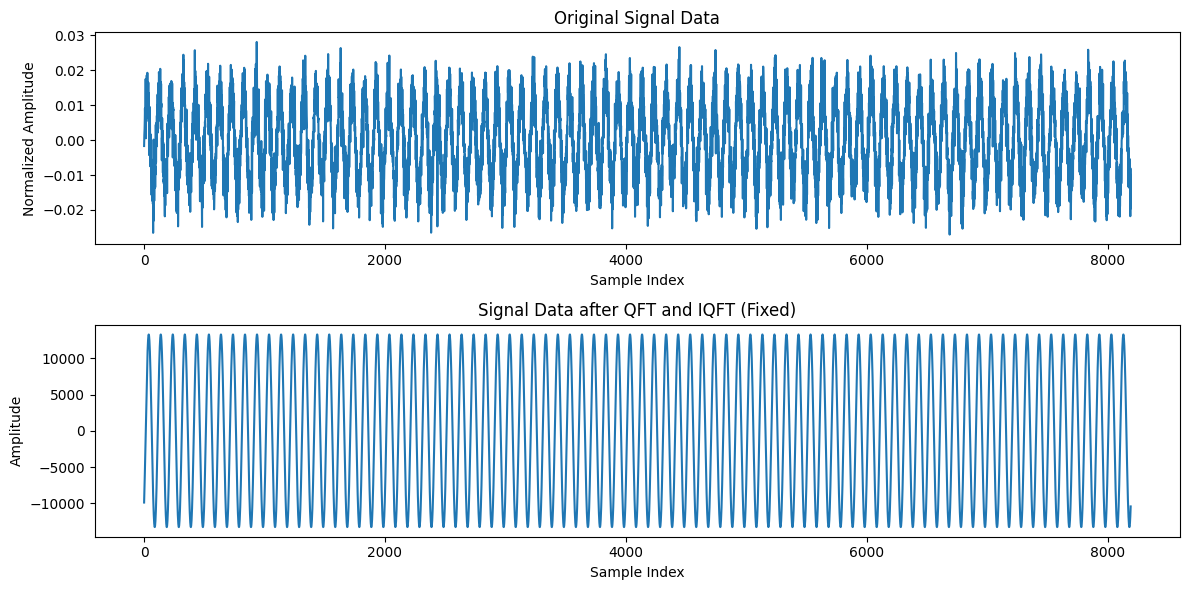

In [ ]:
retrieved_audio = (state.data.real)

retrieved_audio = retrieved_audio * norm_factor  

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(range(2**n_qubits), normalized_audio)
plt.title("Original Signal Data")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")

plt.subplot(2, 1, 2)
plt.plot(range(2**n_qubits), retrieved_audio)
plt.title("Signal Data after QFT and IQFT (Fixed)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [69]:
filtered_audio = np.int16(retrieved_audio) 

output_filename = "quantum_filtered.wav"
write(output_filename, sample_rate, filtered_audio)